# ATP Tennis - SHAP Decision Tree Feature Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import shap
import os
import sys
import logging

logging.basicConfig(level=logging.INFO)

# add relative path to load modules
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper

%matplotlib inline
sns.set()




# Load the saved Model

In [2]:
# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

MODEL_DIR = '../models'
REPORT_DIR = '../reports'

REPORT_FILE = f'{REPORT_DIR}/summary.csv'
MODEL_FILE = f'{MODEL_DIR}/decisiontreeclassifier-1998-2019-diff-ohe_player.pkl'

report = pd.read_csv(REPORT_FILE)
report.head(1)

,model,description,data_file,start_year,accuracy,confusion_matrix,classification_report,model_file
0,LogisticRegression,diff,../datasets/atp_matches_1985-2019_features-dif...,1998,0.693807,"{""0"": {""0"": 4941, ""1"": 2102}, ""1"": {""0"": 2437,...","{""Loss"": {""precision"": 0.7015476359505892, ""re...",../models/logisticregression-1998-2019-diff.pkl


In [3]:
dc_diff_ohe_player_report = report[(report.model == 'DecisionTreeClassifier') &
                                  (report.description == 'diff-ohe_player')]
dc_diff_ohe_player_report

,model,description,data_file,start_year,accuracy,confusion_matrix,classification_report,model_file
8,DecisionTreeClassifier,diff-ohe_player,../datasets/atp_matches_1985-2019_features-dif...,1998,0.937264,"{""0"": {""0"": 6940, ""1"": 492}, ""1"": {""0"": 438, ""...","{""Loss"": {""precision"": 0.933799784714747, ""rec...",../models/decisiontreeclassifier-1998-2019-dif...


In [4]:
mw = ModelWrapper.get_model_wrapper_from_report(dc_diff_ohe_player_report)
mw

INFO:util.model_util:<class 'pandas.core.frame.DataFrame'>
INFO:util.model_util:                    model      description  \
8  DecisionTreeClassifier  diff-ohe_player   

                                           data_file  start_year  accuracy  \
8  ../datasets/atp_matches_1985-2019_features-dif...        1998  0.937264   

                                    confusion_matrix  \
8  {"0": {"0": 6940, "1": 492}, "1": {"0": 438, "...   

                               classification_report  \
8  {"Loss": {"precision": 0.933799784714747, "rec...   

                                          model_file  
8  ../models/decisiontreeclassifier-1998-2019-dif...  


In [5]:
pd.DataFrame(mw.cm)

,0,1
0,6940,438
1,492,6954


In [6]:
pd.DataFrame(mw.cr)

,Loss,Win,accuracy,macro avg,weighted avg
precision,0.933800,0.940747,0.937264,0.937273,0.937289
recall,0.940634,0.933924,0.937264,0.937279,0.937264
f1-score,0.937205,0.937323,0.937264,0.937264,0.937264
support,7378.000000,7446.000000,0.937264,14824.000000,14824.000000


# Load Original Data File

In [7]:
LABEL_COL = 'p1_winner'
X_train, X_test, y_train, y_test = ju.get_data(mw.data_file, LABEL_COL, ModelWrapper.start_year)

INFO:util.jupyter_util:loading ../datasets/atp_matches_1985-2019_features-diff-ohe_player.csv


(59293, 4837)


### In order for some of the our graphs to display better later. We are going to map some of our features back to original non-numerical values

In [8]:
from sklearn.preprocessing import OneHotEncoder


# make a copy of our test data
X_test_unmapped = X_test.copy()

# print(X_test_unmapped.columns)

type_map = {
    "tourney_id_label": np.int32,
    "tourney_level_label": np.int32,
    "tourney_year": np.int32,
    "tourney_month": np.int32,
    "surface_label": np.int32,
    "draw_size": np.int32,
    "round_label": np.int32,
    "rank_diff": np.int32,
    "seed_diff": np.int32,
    "p1_ioc": np.int32,
    "p1_hand": np.int32,
    "p2_ioc": np.int32,
    "p2_hand": np.int32,
}

X_test_unmapped = X_test_unmapped.astype(type_map)
print(X_test_unmapped.info())

def unmap(df: pd.DataFrame, column: str, mapfile: str):
    with open(mapfile, 'r') as file:
        mappings = json.load(file)
    mappings

    reverse_mappings = {value: key for key, value in mappings.items()}


    return df[column].map(reverse_mappings)

    

# unmap surface
X_test_unmapped["surface_label"] = unmap(X_test_unmapped, "surface_label", f'{MODEL_DIR}/surface_map.json')



# unmap round label
X_test_unmapped["round_label"] = unmap(X_test_unmapped, "round_label", f'{MODEL_DIR}/round_map.json')


# unmap p1 and p2 ioc
X_test_unmapped["p1_ioc"] = unmap(X_test_unmapped, "p1_ioc", f'{MODEL_DIR}/ioc_map.json')
X_test_unmapped["p2_ioc"] = unmap(X_test_unmapped, "p2_ioc", f'{MODEL_DIR}/ioc_map.json')

# unmap p1 and p2 hand
X_test_unmapped["p1_hand"] = unmap(X_test_unmapped, "p1_hand", f'{MODEL_DIR}/hand_map.json')
X_test_unmapped["p2_hand"] = unmap(X_test_unmapped, "p2_hand", f'{MODEL_DIR}/hand_map.json')


# unmap tourney_id_label - we should map this back to tournament name
X_test_unmapped["tourney_id_label"] = unmap(X_test_unmapped, "tourney_id_label", f'{MODEL_DIR}/tid_map.json')

# unmap tourney level - we should map this to something more meaningful
# with open(f'{MODEL_DIR}/tourney_level_map.json', 'w') as file:
X_test_unmapped["tourney_level_label"] = unmap(X_test_unmapped, "tourney_level_label", f'{MODEL_DIR}/tourney_level_map.json')


# let's double check our work
X_test_unmapped[["surface_label", "round_label", "p1_ioc", "p2_ioc", "p1_hand", "p2_hand", "tourney_id_label", "tourney_level_label"]].head(1)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14824 entries, 87467 to 54631
Columns: 4837 entries, age_diff to p2_205734.0
dtypes: float64(4824), int32(13)
memory usage: 546.4 MB
None


,surface_label,round_label,p1_ioc,p2_ioc,p1_hand,p2_hand,tourney_id_label,tourney_level_label
87467,clay,f,esp,esp,r,l,717,a


In [9]:
# let's map tourney_id into the actual tournament name

PREPROCESSED_FILE = f'../datasets/atp_matches_1985-2019_preprocessed.csv'
pre = pd.read_csv(PREPROCESSED_FILE, 
                  usecols=["tourney_id", "tourney_name"]).drop_duplicates()
# default tournament id includes the year - we have to strip this out again
pre["tourney_id"] = pre["tourney_id"].apply(lambda x: x.split("-")[1])
tid_map = {row.tourney_id: row.tourney_name for _, row in pre.iterrows()}
X_test_unmapped["tourney_id_label"] = X_test_unmapped["tourney_id_label"].map(tid_map)

# test our work
X_test_unmapped[["surface_label", "round_label", "p1_ioc", "p2_ioc", "p1_hand", "p2_hand", "tourney_id_label", "tourney_level_label"]].head(1)


,surface_label,round_label,p1_ioc,p2_ioc,p1_hand,p2_hand,tourney_id_label,tourney_level_label
87467,clay,f,esp,esp,r,l,houston,a


# SHAP Analysis

In [10]:
shap.initjs()

explainer = shap.TreeExplainer(mw.model)
shap_values = explainer.shap_values(X_test)

In [11]:
shap_df = pd.DataFrame(shap_values[-1], columns=X_test.columns)
print(shap_df.shape)
shap_df.head()

(14824, 4837)


,age_diff,draw_size,ht_diff,p1_hand,p1_ioc,p2_hand,p2_ioc,rank_diff,round_label,seed_diff,...,p2_200611.0,p2_200615.0,p2_200624.0,p2_200630.0,p2_202090.0,p2_202130.0,p2_202358.0,p2_202359.0,p2_202385.0,p2_205734.0
0,-0.003754,-0.008356,-0.000367,-0.000019,-0.000200,0.000296,0.000167,0.070146,-0.006586,-0.509361,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.004102,0.003868,0.000654,-0.000043,0.000863,-0.000138,-0.000393,0.155177,0.020286,0.324937,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.003441,0.013162,-0.000369,-0.000024,0.001253,-0.000052,0.000439,0.186794,-0.003658,0.302168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.004544,0.012831,0.001137,-0.000039,0.000235,-0.000044,-0.000149,0.167558,0.001977,0.315782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000164,0.080259,0.000229,-0.000058,0.000817,-0.000183,-0.126518,-0.000194,-0.099190,-0.289672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
print('Expected Value:', explainer.expected_value)


Expected Value: [0.5039465427398682, 0.49605342745780945]


### Decision Tree Graph

<font color="red">Unfortunately the graph is too big to display here because once we one hot encoded our players, there are just too many features</red>

In [14]:
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus


# dot_data = export_graphviz(mw.model, out_file=None,  
#                feature_names=X_test.columns,
#                class_names=["Loss", "Win"])
# graph = pydotplus.graph_from_dot_data(dot_data)  
# Image(graph.create_png())
# graph.write_png("graph.png")

### Feature importance for our highest performing model

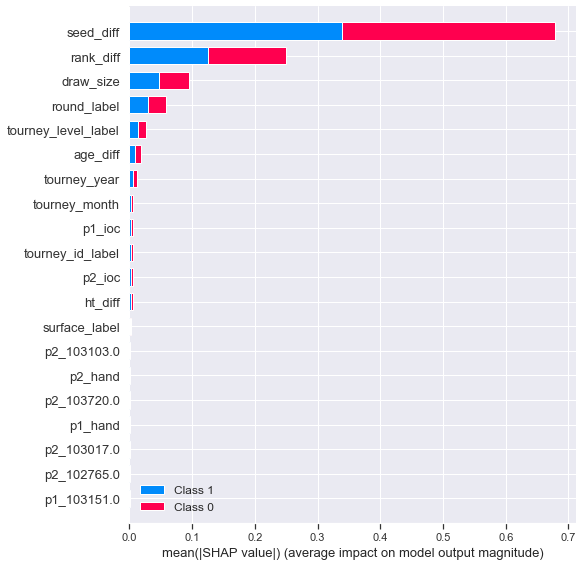

In [15]:
shap.summary_plot(shap_values, feature_names=X_test.columns, title="Feature Importance")

In [16]:
mw.X_test = X_test
y_predict_df = mw.predict()
correct_indexes = (y_predict_df == y_test.tolist())
correct_indexes

array([ True,  True,  True, ...,  True,  True,  True])

In [17]:
y_predict_mapped = pd.Series(y_predict_df).map({0: "Loss", 1: "Win"})
y_predict_mapped

0        Loss
1         Win
2         Win
3         Win
4        Loss
         ... 
14819     Win
14820    Loss
14821    Loss
14822    Loss
14823    Loss
Length: 14824, dtype: object

In [18]:
true_idxs = np.flatnonzero(correct_indexes)
true_idxs

array([    0,     1,     2, ..., 14821, 14822, 14823])

# Summary Plot

<font color="red">I'm assuming index 1 of shap_values corresponds to how the model predicts Wins??</font>

* seed_diff - better seed (blue) tends to push the model towards predicting wins. However, there is a cluster of outliers at the left of the violin plot that suggests that if p1 is ranked much higher than p2, the model is predicting a major upset in some cases
* rank_diff - this one is a little bit more consistent with what we would expect. you see blues with higher SHAP values and RED's with less SHAP values
* draw_size - model is actually predicting more upsets in later rounds as you see blues with negative SHAP values
* age_diff - model is generally predicting younger players will win as you see more blues and purples with positive SHAP values

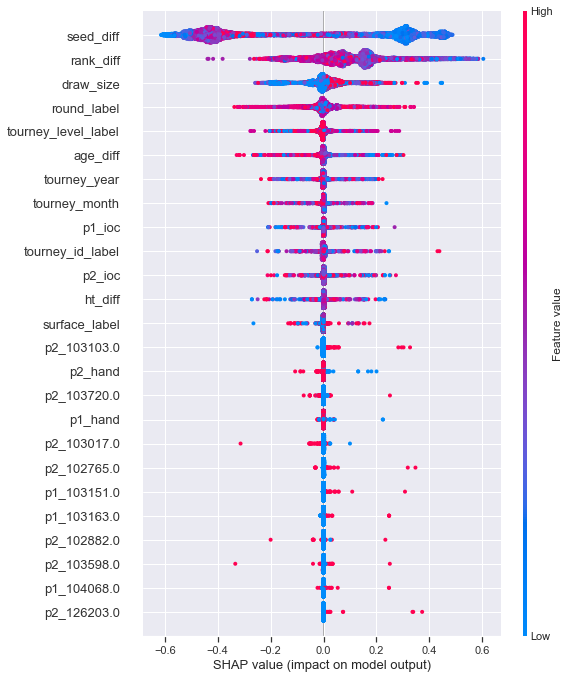

In [19]:
shap.summary_plot(shap_values[1], X_test, max_display=25)

# Look at Correct Predictions

<font color="red">I'm not sure what the 2 different arrays of the expected_value and shap_values here mean. Documentation was a little bit unclear. They seem to be reverse of each other. I'm thinking 0 index might be what the model is doing when predicting losses?</font>

In [20]:
true_idx1 = np.random.choice(true_idxs)
print(f'Prediction: {y_predict_mapped[true_idx1]}')
shap.force_plot(explainer.expected_value[0], shap_values[0][true_idx1][:], X_test_unmapped.iloc[true_idx1,:], feature_names=X_test.columns)

Prediction: Loss


In [21]:
shap.force_plot(explainer.expected_value[1], shap_values[1][true_idx1][:], X_test_unmapped.iloc[true_idx1,:], feature_names=X_test.columns)

In [22]:
true_idx2 = np.random.choice(true_idxs)
print(f'Prediction: {y_predict_mapped[true_idx2]}')
shap.force_plot(explainer.expected_value[0], shap_values[0][true_idx2][:], X_test_unmapped.iloc[true_idx2,:], feature_names=X_test.columns)

Prediction: Loss


In [23]:
shap.force_plot(explainer.expected_value[1], shap_values[1][true_idx2][:], X_test_unmapped.iloc[true_idx2,:], feature_names=X_test.columns)

# Look at incorrect predictions

In [40]:
incorrect_indexes = (y_predict_df != y_test.tolist())
false_idxs = np.flatnonzero(incorrect_indexes)

In [43]:
false_idx1 = np.random.choice(false_idxs)
print(f'Prediction: {y_predict_mapped[false_idx1]}')
shap.force_plot(explainer.expected_value[0], shap_values[1][false_idx1][:], X_test_unmapped.iloc[false_idx1,:], feature_names=X_test.columns)

Prediction: Loss


Here model predict player 1 would win based on:
* player 1 is ranked higher than player 2
* draw size was 128
* round of 32

But this was an upset and player 1 actually lost

In [45]:
false_idx2 = np.random.choice(false_idxs)
print(f'Prediction: {y_predict_mapped[false_idx2]}')
shap.force_plot(explainer.expected_value[0], shap_values[1][false_idx2][:], X_test_unmapped.iloc[false_idx2,:], feature_names=X_test.columns)

Prediction: Win


# Let's look at partial dependence plot

Background:
* If player 1 is ranked higher (ie, #1) than player 2 (ie, #5), seed_diff is negative -> player 1 is expected to beat player 2
* Conversely if player 1 has lower rank than player 2, seed_diff is positive -> player 2 is expected to beat player 1
* draw size here is not mapped or normalized so the number corresponds to how many players are in the tournament


In [27]:
print(shap_df.shape)
shap_df[["draw_size"]].describe()

(14824, 4837)


,draw_size
count,14824.000000
mean,0.004284
std,0.074394
min,-0.258584
25%,-0.015494
50%,0.003878
75%,0.033996
max,0.448122


### Look at Draw Size and SHAP values

Not a whole lot to conclude as all bars are almost symmetrical around 0.0 SHAP value. With the exceptions: 
*  draws of 128, the model skews more to postive SHAP values and tends to predict player 1 will beat player 2 
* draws of 32, there are some outlier SHAP values that are postive that also would predict player 1 will beat player 2

We will look at how this interacts with out variables later

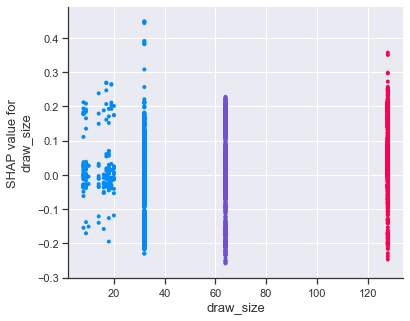

In [28]:
shap.dependence_plot(ind='draw_size', interaction_index='draw_size',
                     shap_values=shap_values[1], 
                     features=X_test,  
                     display_features=X_test_unmapped)

### Seed Diff and Draw Size PDP - model predicts upsets more during first couple rounds

This is now getting a little bit more interesting. 

Background:
* Blue - expected win - player 1 is seeded higher than player 2 (around 20 or more)
* purple - upset - player 1 is ranked somewhere between 0 to 20 lower than player 2
* red -  major upset - player 1 is seeded much lower than player 2 (around 50 or more)

Analysis:
* tournamennts draw size < 32 - model is generally predicting that if player 1 is ranked higher than player 2 the model predicts player 1 to be the winner
* draw size 32 - the model is expecting upsets as you can see a purple section between 0.15 to slightly above 0.2 if player 1 is only rnaked somewhere betwwen 0 and 20 seeds lower than player 2
* draw size 64 - this is actually really interesting.. the model is actually expecting lots of upsets as you see that blues have SHAP values of 0 or below and purples are above 0.0
* for grand slams (draw size 128) - the model is also predicting a fair amount of upsets as you see lots of blue with SHAP values under 0.0. Interesting, the model is predicting major upsets as you see a lot of red with SHAP values between 0.1 and 0.2

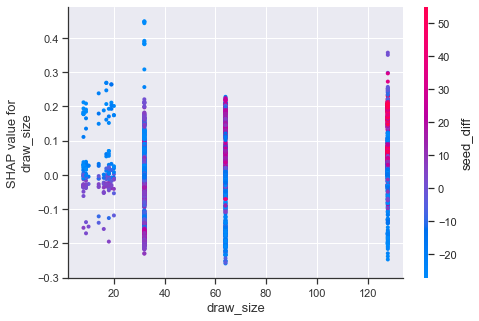

In [29]:
shap.dependence_plot(ind='draw_size', interaction_index='seed_diff',
                     shap_values=shap_values[1], 
                     features=X_test,  
                     display_features=X_test_unmapped)

## Let's see how our players do in different rounds of the tournament

#### Players
As you move from finals to early rounds, you see the color of the graph changing. As you move to earlier rounds (ie, r64) you see more reds and blues meaning that there is more of a gap between seed difference in the early round matches. By finals, you are mostly seeing players that are within 10 to 20 seeds of each other 

#### Predictions

* In general, you are seeing the absolute SHAP values decrease as the tournament progresses, meaning that the model is using the rounds less to base it's prediction as the tournament progresses
* Finals -  model is generally predicting player with higher rank will win as you see more blue above SHAP values of 0.0 than you do below 0.0. However there is an outlier with -0.3
* Semi's to r16 - not very interesting here as the graph is pretty symmetrics around 0.0 as well as color are sprinkled through on both above and below 0.0. Although you actually see more blue centered around 0.0 meaning that if player 1 is ranked higher than player 2, this information is actually less meaningful to the model than the other 2 types of matches
* r64 and r128 - this one is interesting.. you now see blue at the extremes of the bar meaning that in these two rounds, the model is using this information a lot more to predict wins and losses. Although from this alone, we cannot tell when it will predict a win or a loss


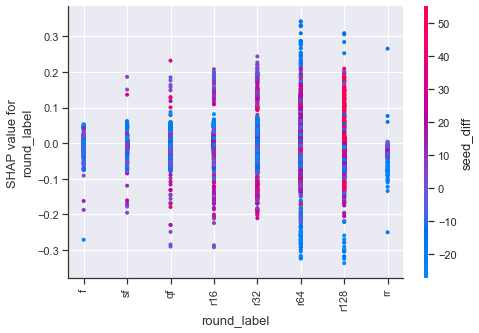

In [30]:
shap.dependence_plot(ind='round_label', interaction_index='seed_diff',
                     shap_values=shap_values[1], 
                     features=X_test,  
                     display_features=X_test_unmapped)

## Age Difference and SHAP values

<font color="red">not sure if I'm interpretting this correctly</font>

Blue means player 1 is younger than player.

For the most part, the model doesn't think this makes a different as most of our points around clustered around 0.0 SHAP values. However, in come cases the model is leaning towards younger player beating the older player as you see blue dots with SHAP values up to 0.3 and red dots with SHAP values beyond -0.3. As the age difference becomes more extreme, the model starts to use this information more as you see the cluster around 0.0 tappering as we go out on both sides

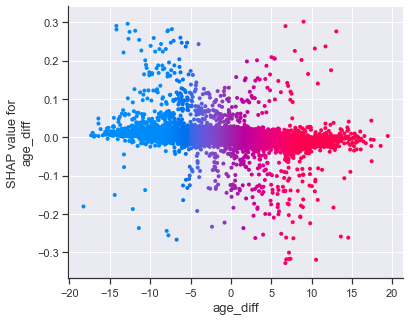

In [31]:
shap.dependence_plot(ind='age_diff', interaction_index='age_diff',
                     shap_values=shap_values[1], 
                     features=X_test,  
                     display_features=X_test_unmapped)

# Age difference as we progress in tournament

This is subtle but age difference actually because higher as you move to later rounds of the tournament as you see the graph goes from more purple to eary rounds to more read in final rounds

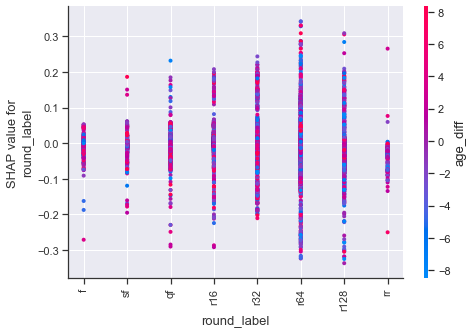

In [32]:
shap.dependence_plot(ind='round_label', interaction_index='age_diff',
                     shap_values=shap_values[1], 
                     features=X_test,  
                     display_features=X_test_unmapped)

## Height Difference

* blue - player 1 is much shorter than player 2
* purple - player 1 is around teh same height as player 2
* red - player 1 is much taller than player 2

Not super interesting here as you see most values around 0.0 SHAP with some outliers. Although you see the highest and lowest SHAP values come from when player 1 is is 10 to 20 cm shorter than player 2

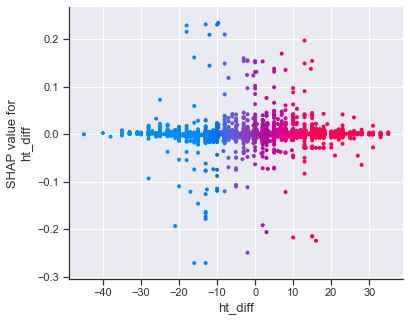

In [33]:
shap.dependence_plot(ind='ht_diff', interaction_index='ht_diff',
                     shap_values=shap_values[1], 
                     features=X_test,  
                     display_features=X_test_unmapped)

Distribution of height difference is pretty evenly distributed as we do not see large bars of red, blue, or purple.

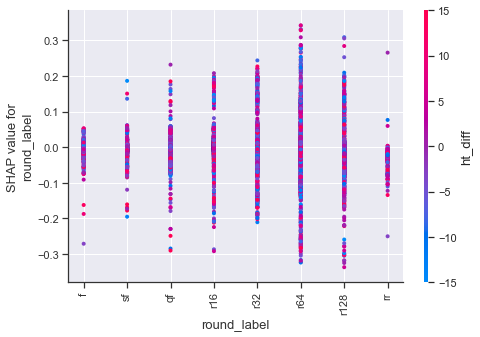

In [34]:
shap.dependence_plot(ind='round_label', interaction_index='ht_diff',
                     shap_values=shap_values[1], 
                     features=X_test,  
                     display_features=X_test_unmapped)

# Left handed players have a slight advantage over right handed players

Model thinks left handed players tend to beat right handed players as you the SHAP values being a little bit higher.

When right handed player playere left handed player, model gives it a 0.0 SHAP value which means the model is not using this information for predictions

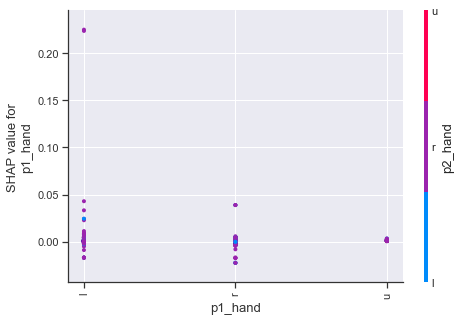

In [35]:
shap.dependence_plot(ind='p1_hand', interaction_index='p2_hand',
                     shap_values=shap_values[1], 
                     features=X_test,  
                     display_features=X_test_unmapped)

# Model uses hard court then grass to predict results more than other surfaces

Models doesn't this information much when the surface is carpet

As we move to the right on the graph, the model starts using this information more for prediction - with hard court being the most important for predicting results out of the 4 surfaces

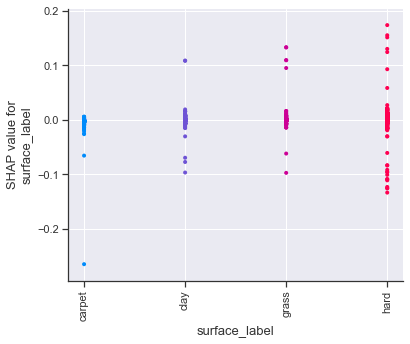

In [36]:
shap.dependence_plot(ind='surface_label', interaction_index='surface_label',
                     shap_values=shap_values[1], 
                     features=X_test,  
                     display_features=X_test_unmapped)

# Player Origin

There are too many player IOC's to look at. Instead we will see if there are certain IOCs that have either high or low SHAP values

In [57]:
player_ioc = X_test_unmapped[["p1_ioc", "p2_ioc"]].copy()
print(player_ioc.shape)
print(player_ioc.head())
ioc_shap = shap_df[["p1_ioc", "p2_ioc"]].rename({"p1_ioc": "p1_ioc_shap", "p2_ioc":"p2_ioc_shap"}, axis=1)
print(ioc_shap.shape)
print(ioc_shap.head())

# we can't use pd.concat for this since the indexes from X_test is different than our indexes for the shap values
# this created a 29k x 4 data file for some reason
# we will have to set these manually
pd.concat([ioc_shap, player_ioc], ignore_index=True, axis=1).shape
idx = 0
for rowidx, row in player_ioc.iterrows():
    player_ioc.loc[rowidx, "p1_ioc_shap"] = ioc_shap.iloc[idx].p1_ioc_shap
    # p2 values are flipped from p1 values, if we are going to put them together we have to flip the sign
    player_ioc.loc[rowidx, "p2_ioc_shap"] = -1 * ioc_shap.iloc[idx].p2_ioc_shap
    idx += 1

player_ioc.head()

(14824, 2)
      p1_ioc p2_ioc
87467    esp    esp
41049    ger    crc
90848    srb    cro
73773    srb    esp
77482    fra    rus
(14824, 2)
   p1_ioc_shap  p2_ioc_shap
0    -0.000200     0.000167
1     0.000863    -0.000393
2     0.001253     0.000439
3     0.000235    -0.000149
4     0.000817    -0.126518


,p1_ioc,p2_ioc,p1_ioc_shap,p2_ioc_shap
87467,esp,esp,-0.000200,-0.000167
41049,ger,crc,0.000863,0.000393
90848,srb,cro,0.001253,-0.000439
73773,srb,esp,0.000235,0.000149
77482,fra,rus,0.000817,0.126518


In [58]:
### Since players are randomly selected as p1 or p2, we can merge the 2 columns
final_ioc = pd.concat([player_ioc[["p1_ioc", "p1_ioc_shap"]].rename({"p1_ioc": "ioc", "p1_ioc_shap": "ioc_shap"}, axis=1), 
                       player_ioc[["p2_ioc", "p2_ioc_shap"]].rename({"p2_ioc": "ioc", "p2_ioc_shap": "ioc_shap"}, axis=1)])
final_ioc.shape

(29648, 2)

In [73]:
final_ioc.describe()

,ioc_shap
count,29648.000000
mean,-0.000144
std,0.012529
min,-0.273707
25%,-0.000788
50%,-0.000080
75%,0.000610
max,0.268798


### Players from Malyasia have a slight advantage over other players as SHAP value is the highest mean of all countries

In [72]:
max_ioc = final_ioc.groupby("ioc").mean()["ioc_shap"].idxmax()
print(f'Max ioc for {max_ioc} with value {final_ioc[final_ioc.ioc == max_ioc].max()}')

Max ioc for mas with value ioc                mas
ioc_shap    0.00512522
dtype: object


### Model seems to think Turkish players will do the worst overall with the lowest mean for SHAP values

In [75]:
min_ioc = final_ioc.groupby("ioc").mean()["ioc_shap"].idxmin()
print(f'Max ioc for {min_ioc} with value {final_ioc[final_ioc.ioc == min_ioc].min()}')

Max ioc for tur with value ioc              tur
ioc_shap   -0.112793
dtype: object


# Players

There are certain player numbers the model is using to predict win or loses. Let's see who those players are. Here are the player ID's

* p2_130130
* p2_103017
* p2_102765
* p1_103151
* p1_103163
* p2_102882
* P2_103598
* p1_104068
* p2_126203

In [77]:
players = pd.read_csv("../datasets/players.csv")

In [81]:
players.head()

,id,name,ht,hand,ioc,wins,losses,matches,pro_date,retire_date,years_as_pro,birthday
0,101381,aaron krickstein,183.0,R,USA,347,233,580,1985-01-08,1996-03-18,11,1967-08-08
1,102778,abdul hamid makhkamov,NaN,R,UZB,0,1,1,1997-09-08,1997-09-08,1,1976-04-24
2,108993,abdulla hajji,NaN,U,QAT,0,3,3,2007-12-31,2010-01-04,3,1990-12-11
3,101676,adam anderson,180.0,R,AUS,0,2,2,1988-01-11,1989-01-16,1,1969-12-27
4,104360,adam chadaj,178.0,L,POL,1,1,2,2005-08-01,2005-08-01,1,1984-05-07


In [83]:
players[players.id.isin([130130, 103017, 102765, 103151, 103163, 102882, 103598, 104068, 126203])]

,id,name,ht,hand,ioc,wins,losses,matches,pro_date,retire_date,years_as_pro,birthday
1473,103151,mariano zabaleta,183.0,R,ARG,201,208,409,1995-07-31,2008-01-28,13,1978-03-08
1506,102882,mark philippoussis,196.0,R,AUS,302,196,498,1994-01-17,2006-08-28,12,1976-11-13
1725,102765,nicolas escude,185.0,R,FRA,159,129,288,1993-05-24,2004-07-26,11,1976-04-08
1728,103017,nicolas kiefer,183.0,R,GER,349,263,612,1994-10-10,2010-06-21,16,1977-07-13
2003,104068,robby ginepri,183.0,R,USA,184,203,387,2001-03-19,2014-08-17,13,1982-10-12
2267,126203,taylor harry fritz,NaN,R,USA,56,60,116,2015-06-21,2019-02-18,4,1997-11-01
2359,103163,tommy haas,188.0,R,GER,543,334,877,1996-08-12,2017-07-31,21,1978-04-09
2455,103598,xavier malisse,185.0,R,BEL,282,266,548,1998-02-23,2013-08-26,15,1980-07-25


### For Tommy Haax the model is pushing the prediction to him losing as player 2

Model tends to predict Tommy Haas will be the winner of matches as the SHAP values are aboove 0

In [101]:
haas_indexes = (X_test["p1_103163.0"] == 1)
shap_df[haas_indexes.tolist()]["p1_103163.0"].describe()

count    103.000000
mean       0.013474
std        0.047750
min        0.000717
25%        0.001344
50%        0.001931
75%        0.003749
max        0.248038
Name: p1_103163.0, dtype: float64

* He beats players with lower ranking and loses to players with higher rankins as you see blue's with positive SHAP values and reds with negative SHAP values
* He playes better with larger draw sizes as you see negative SHAP values with blue draw sizes
* he also has a tendency to lost in earlier rounds of a tournament as you see negative SHAP values with red for round_label

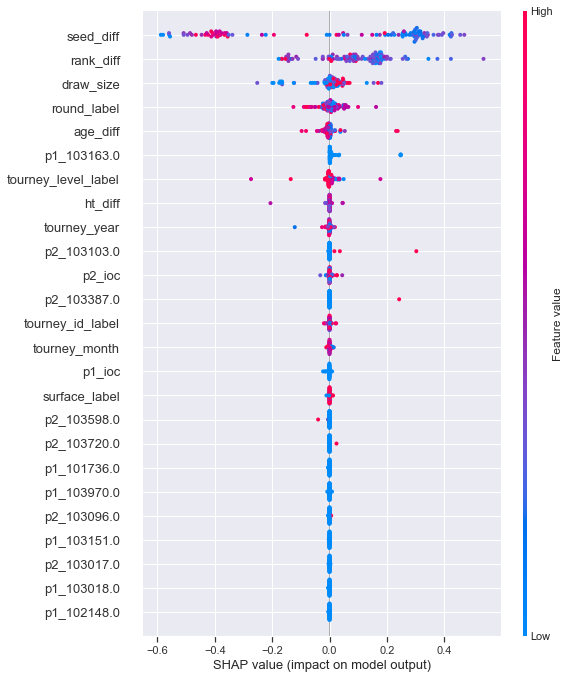

In [111]:
shap.summary_plot(shap_values[1][haas_indexes.tolist()], X_test[haas_indexes.tolist()], max_display=25)

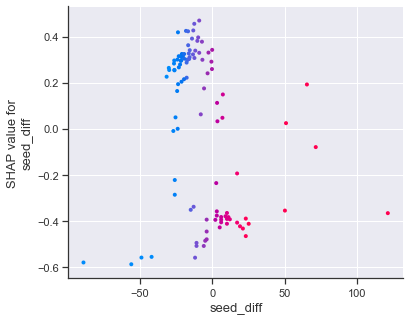

In [119]:
shap.dependence_plot(ind='seed_diff', interaction_index='seed_diff',
                     shap_values=shap_values[1][haas_indexes.tolist()], 
                     features=X_test[haas_indexes.tolist()],  
                     display_features=X_test_unmapped[haas_indexes.tolist()])

### Let's look at data from Federer and how the model is predicting his matches

* you see bigger clusters of blue with positive seed_diff SHAP values meaning that he tends to beat opponents that are lower seed
* model also seems to think that he rarely loses to lower ranked players as you mostly only see read with negative SHAP values in rank_diff
* like Haas, model tends to start predicting more losses in earlier rounds as you see red/negative SHAP values in round_label

In [103]:
players[players.name == "roger federer"]

,id,name,ht,hand,ioc,wins,losses,matches,pro_date,retire_date,years_as_pro,birthday
2037,103819,roger federer,185.0,R,SUI,1160,256,1416,1998-07-06,2019-02-25,21,1981-08-13


In [108]:
federer_indexes = (X_test["p1_103819.0"] == 1)
shap_df[federer_indexes.tolist()]["p1_103819.0"].describe()

count    182.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: p1_103819.0, dtype: float64

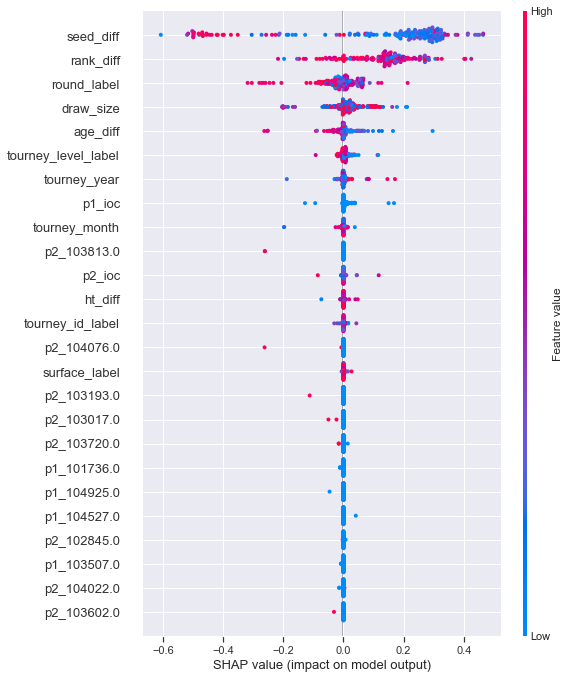

In [110]:
shap.summary_plot(shap_values[1][federer_indexes.tolist()], X_test[federer_indexes.tolist()], max_display=25)

### Model is mostly predicting that Federer will win when his is the higher seed. When is is the lower seed, the models weights is slightly more to predict losses as the SHAP values goes beyond -0.4

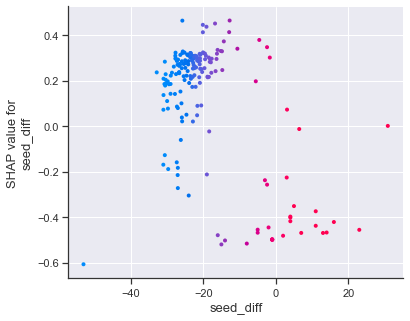

In [124]:
shap.dependence_plot(ind='seed_diff', interaction_index='seed_diff',
                     shap_values=shap_values[1][federer_indexes.tolist()], 
                     features=X_test[federer_indexes.tolist()],  
                     display_features=X_test_unmapped[federer_indexes.tolist()])

In [ ]:
### Model generally predicts Federer will win in the first 2 rounds of tournament (r128, r64). Thinks he generally wins in r32. Beyond that, it's pretty event between winning or losing. As we get closer to the ifnal,

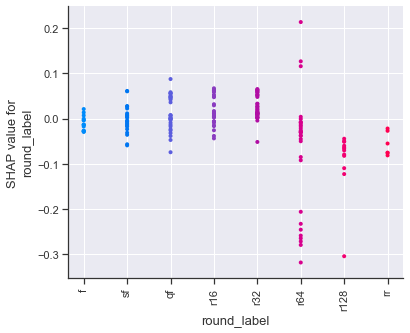

In [127]:
shap.dependence_plot(ind='round_label', interaction_index='round_label',
                     shap_values=shap_values[1][federer_indexes.tolist()], 
                     features=X_test[federer_indexes.tolist()],  
                     display_features=X_test_unmapped[federer_indexes.tolist()])

### From 2007 on, model is leading towards predicting winw for Federer

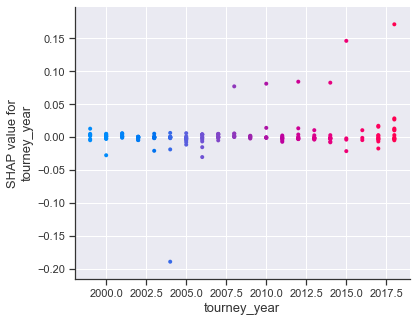

In [120]:
shap.dependence_plot(ind='tourney_year', interaction_index='tourney_year',
                     shap_values=shap_values[1][federer_indexes.tolist()], 
                     features=X_test[federer_indexes.tolist()],  
                     display_features=X_test_unmapped[federer_indexes.tolist()])

## Model thinks Federer is week on carpet but but he does better on clay and hard court surfaces

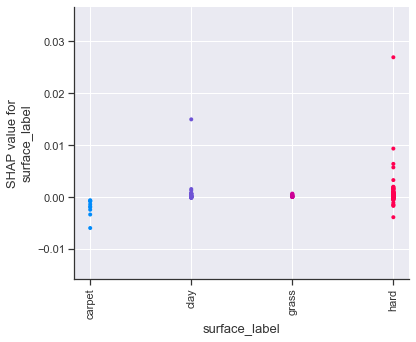

In [114]:
shap.dependence_plot(ind='surface_label', interaction_index='surface_label',
                     shap_values=shap_values[1][federer_indexes.tolist()], 
                     features=X_test[federer_indexes.tolist()],  
                     display_features=X_test_unmapped[federer_indexes.tolist()])

### Model thinks that Federer does better on grand slaps, and ok on masters series, and not so great on year end finals and othe tournaments

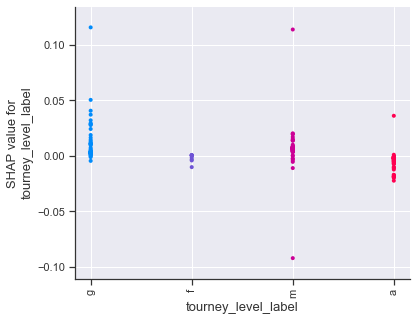

In [118]:
shap.dependence_plot(ind='tourney_level_label', interaction_index='tourney_level_label',
                     shap_values=shap_values[1][federer_indexes.tolist()], 
                     features=X_test[federer_indexes.tolist()],  
                     display_features=X_test_unmapped[federer_indexes.tolist()])